# Exercises

## Setup

In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

## Exercise 1: Make some art

In the section "The world's simplest model" from "Lesson 2: Regression Refresher" we created the following visualization.

<center>
    <img src="imgs/intercept_only_model_curve.png" style="width:950px;"/>
</center>

This allowed us to see the intercept-only model fits a flat line that is not affected by the values of the predictor. 

You're asked to reproduce this visualization, usin the Bambi model we created in this lesson. Fortunately, you don't need to write a lot of code from scratch. Use the snippet from Lesson 2 and find the places where you need to change parameter names. 

```python
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.scatter(x=data["Length1"], y=data["Weight"], alpha=0.6)
ax.set(xlabel="Length (centimeters)", ylabel="Weight (grams)", title="Fish length vs weight")

for value in idata.posterior["β0"].to_numpy().flatten()[::10]:
    ax.axhline(value, color="C1", alpha=0.2)

β0_mean = idata.posterior["β0"].to_numpy().mean()
ax.axhline(β0_mean, color="C4")

handles = [
    Line2D([], [], label="Observations", lw=0, marker="o", color="C0", alpha=0.6),
    Line2D([], [], label="Posterior draws", lw=2, color="C1"),
    Line2D([], [], label="Posterior mean", lw=2, color="C4"),
]
ax.legend(handles=handles, loc="upper left")
```

In [32]:
fish_data = pd.read_csv("data/fish-market.csv")
fish_data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


## Exercise 2: Deepen your `plot_cap()` knowledge

In this exercise you have to work with the fish data and the model we created in the "Transformations in Bambi" section. More concrete, you need to build the following model

```python
model = bmb.Model("log(Weight) ~ 1 + log(Length1)", data)
```
Notice you need to import the data to solve this exercise. Then create and fit the model mentioned above, and use `plot_cap()` with `Length1` as the variable for the horizontal axis.

```python
plot_cap(model, idata, "Length1")
```

Answer the following questions

* What do you see?
* What is the scale of the variables in the horizontal and the vertical axis? Consider they're used with an inline transformation in the model.
    * Why?
* How can you put both variables in the transformed scale?
* And how you put everything on the untransformed scale?

## Exercise 3: Advanced operators

In the section "Transformations in Bambi" we showed that some custom operations needed to be written using a particular syntax. In this exercise you're going to experiment a little with with these operations to see how they work in practice. The goal here is not to arrive to a "correct" answer, but to see what are the different results when we try different formulas and trying to understand what's going on. Use the following simulated data:

In [17]:
rng = np.random.default_rng(1211)
size = 100
df = pd.DataFrame(
    {
        "response": rng.normal(loc=5, scale=0.5, size=size),
        "x": rng.normal(loc=10, scale=2, size=size),
        "y": rng.normal(size=size),
    }
)

Use the following formulas and explain what's happening

* `"response ~ x / 100`"
* `"response ~ x ** 100"`
* `"response ~ x / y"`
* `"response ~ (x + y) ** 2"`

It's fine if you can only describe what you see. At this point you're not expected to be an expert in formula notation. We'll cover more advanced stuff later in the course.

What is the difference between `"response ~ x + y"` and `"response ~ I(x + y)"`?

## Exercise 4: Experiment!

In the "Parameter identifiability" section we simulated some data to grasp what non-identifiability means using a controlled scenario. The code we used is the following:

In [18]:
rng = np.random.default_rng(1234)
b0, b1 = 0.5, 2.5
x = np.linspace(0, 3, num=50)
noise = rng.normal(scale=0.5, size=50)
y = b0 + b1 * x + noise

And then we created the following PyMC model

In [19]:
with pm.Model() as weird_model:
    b0 = pm.Normal("b0", sigma=0.5)
    b1 = pm.Normal("b1")
    b2 = pm.Normal("b2")
    mu = b0 + b1 * x + b2 * x
    sigma = pm.HalfNormal("sigma" ,sigma=0.5)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

The goal of this exercise is to have you run several experiments to understand how parameter non-identifiablity affects sampling times and the quality of the draws obtained. You are asked to

* Repeat this experiment with different sample sizes.
    * Use $n=500$ and $n=2000$
* Explore the posterior of the slopes
* Change the seeds and comment on the posterior results
* Do you get any warnings?
* Explore ESS and R-hat
* Explore the correlation between $b_1$ and $b_2$. 
    * Does it improve with more data?

Now, use the correct model, with a single slope

```python
with pm.Model() as good_model:
    b0 = pm.Normal("b0", sigma=0.5)
    b1 = pm.Normal("b1")
    mu = b0 + b1 * x
    sigma = pm.HalfNormal("sigma" ,sigma=0.5)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)
```

* Fit it using $n=500$ and $n=2000$, as done previously
* Compare the sampling speed with the previous model
    * What can you conclude about the effects of parameter correlations in sampling speed?
* Can you recover the true slope?
* Do you get any warnings? Again explore ESS and R-hat.
* Also explore the correlation between model parameters. 
    * What can you conclude?

Finally, you're asked to reproduce the flawed model in Bambi. To do so, you need to use the formula `"y ~ x + x"`. 

* What happens?
* Why do you think it works that way?

## Exercise 5: Try different numerical predictors

In the section "An end to end trip with Bambi" we computed the $R^2$ coefficient of the following model

```python
model = bmb.Model("log(Weight) ~ 0 + Species + log(Length1):Species", data)
```

We got an $R^2$ equal to 0.984, which is very high. 

In this exercise you're asked to use the other numerical predictors in the dataset in place of `Length1`, compute the $R^2$ of those models, and compare to what we got with `Length1`.

**Notes**

You have to create two extra models. One using `Height` and other using `Width` as predictors. You can keep the same strcuture of varying intercepts and varying slopes. 

**Optional**

Combine two or more of the numerical predictors, compute the $R^2$ coefficient, and compare with the previous models. Does adding more numerical predictors improve $R^2$?

## Exercise 6: Interaction effects

In this exercise we're going to learn more about interaction effects. In the section "The full model" we covered that the different `log(Length)` slopes per `Species` is an interaction between `log(Length)` and `Species`. More generally, this is an interaction between a numeric and a categorical variable. The result was as many slopes as species in our dataset.

Now we're going to exercise another type of interaction, between two numerics, which is the first case in the following diagram.

<center>
  <img src="imgs/interaction_symbol.png" style="width:950px"; />
</center>

We expect this to give us a single new slope, which is multiplied by the product of the two numerical covariates.

### The data

In [20]:
mtcars_data = pd.read_csv("data/mtcars.csv")
mtcars_data.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973--74 models). The following is a description of the variables:

* `mpg`: Miles/(US) gallon
* `cyl`: Number of cylinders
* `disp`: Displacement (cu.in.)
* `hp`: Gross horsepower
* `drat`: Rear axle ratio
* `wt`: Weight (1000 lbs)
* `qsec`: 1/4 mile time
* `vs`: Engine (0 = V-shaped, 1 = straight)
* `am`: Transmission (0 = automatic, 1 = manual)
* `gear`: Number of forward gears

## The models

We're going to us the Gross horsepower (`hp`) and the Weight (`wt`) to predict the fuel consumption in Miles per US gallon (`mpg`).

**Main effects model**

$$
\text{mpg} = \beta_0 + \beta_1 \text{hp} + \beta_2 \text{wt} + \varepsilon
$$

**Interaction effects model**

$$
\text{mpg} = \beta_0 + \beta_1 \text{hp} + \beta_2 \text{wt} + \beta_3 \text{hp} \cdot \text{wt}  + \varepsilon
$$

* Build and fit the main effects model
* Build and fit the model with the interaction effects
* Explore the posterior of both models
    * What can you conclude about the coefficient of the interaction effect?
* Use `plot_cap()` to compare the fitted curves
    * Map `hp` to the horizontal axis and `wt` to the color or the panel.
    * Can you describe how the interaction affects the fitted curves?

In [21]:
model_main = bmb.Model("mpg ~ 1 + hp + wt", mtcars_data)
idata_main = model_main.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, hp, wt, mpg_sigma]


In [ ]:
model_interaction = bmb.Model("mpg ~ 1 + hp + wt + hp:wt", mtcars_data)
idata_interaction = model_interaction.fit(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, hp, wt, hp:wt, mpg_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


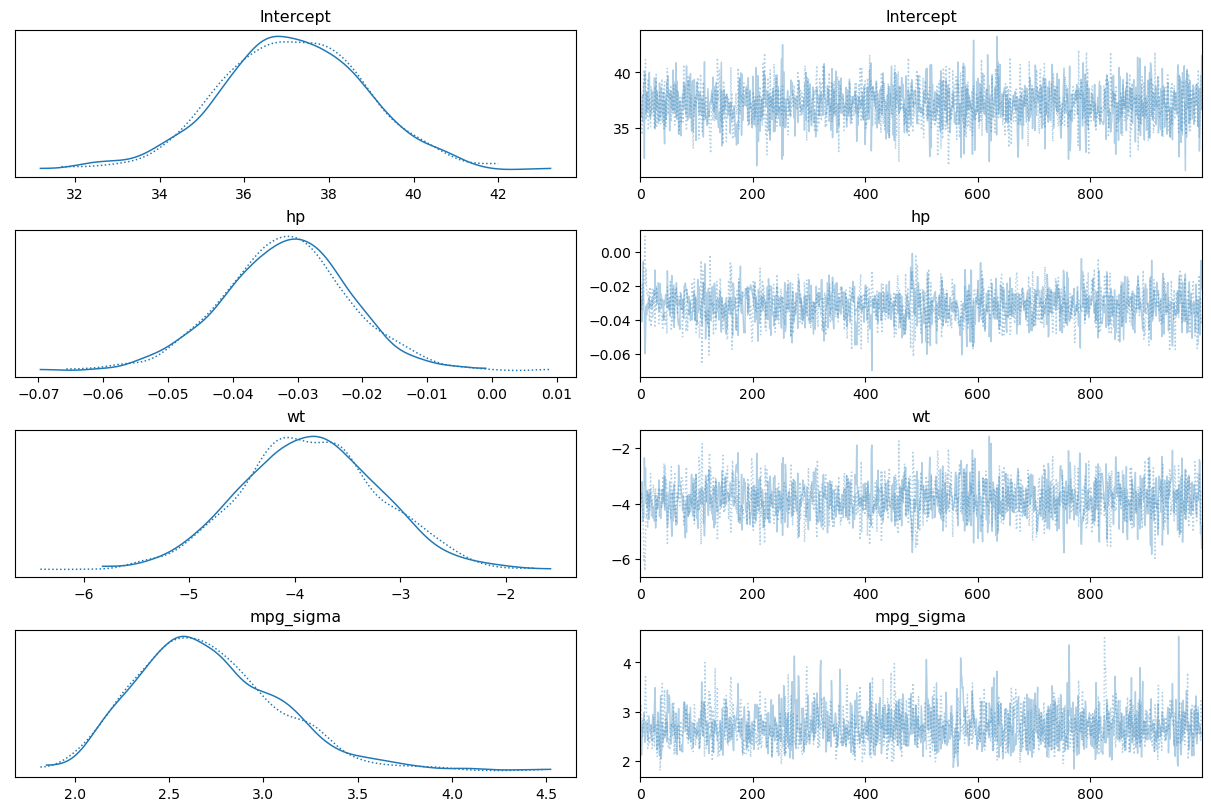

In [ ]:
az.plot_trace(idata_main, backend_kwargs={"layout": "constrained"});

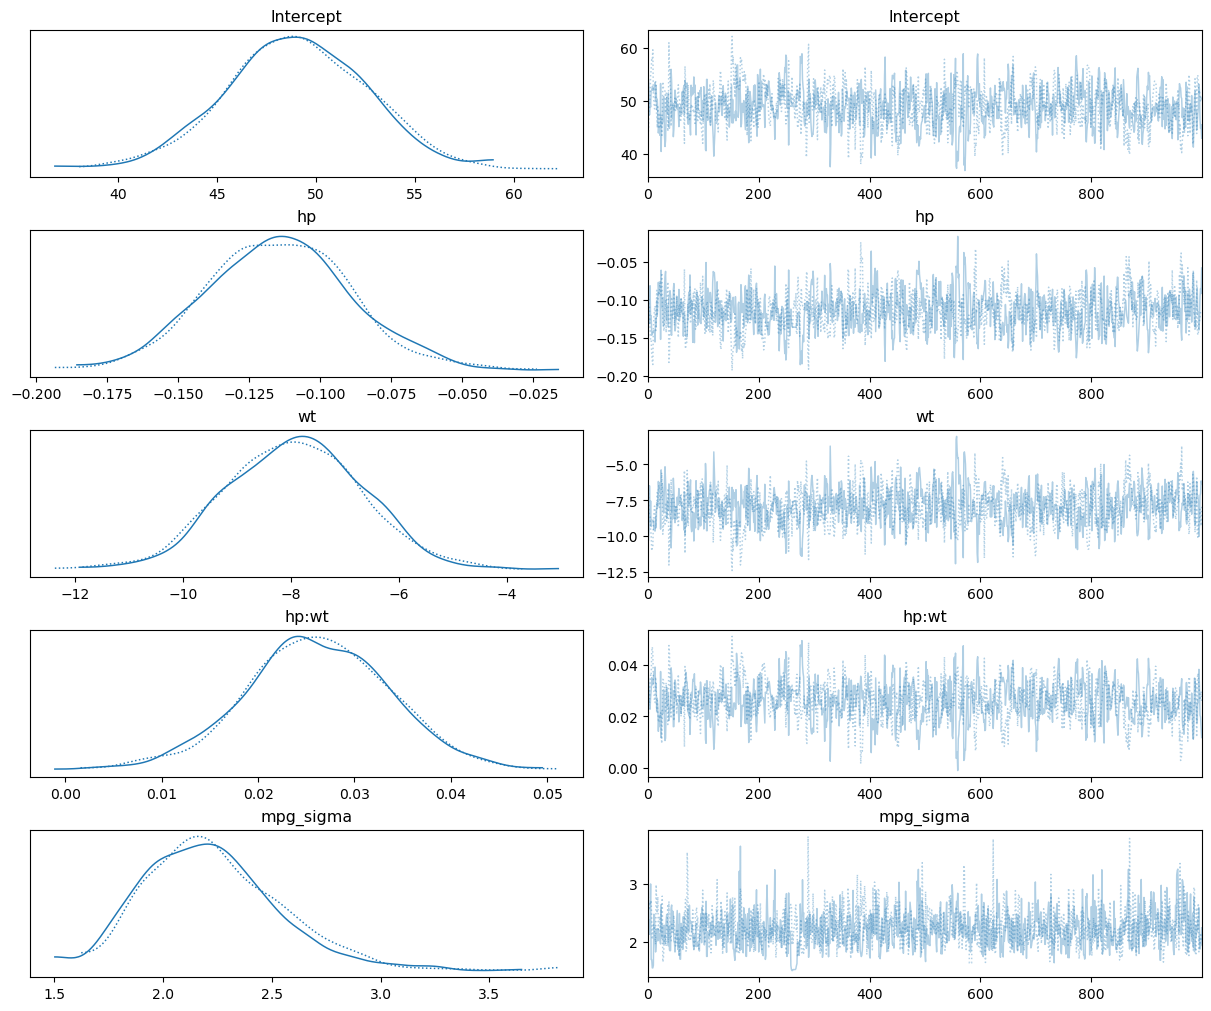

In [ ]:
az.plot_trace(idata_interaction, backend_kwargs={"layout": "constrained"});

In [ ]:
from bambi.plots import plot_cap

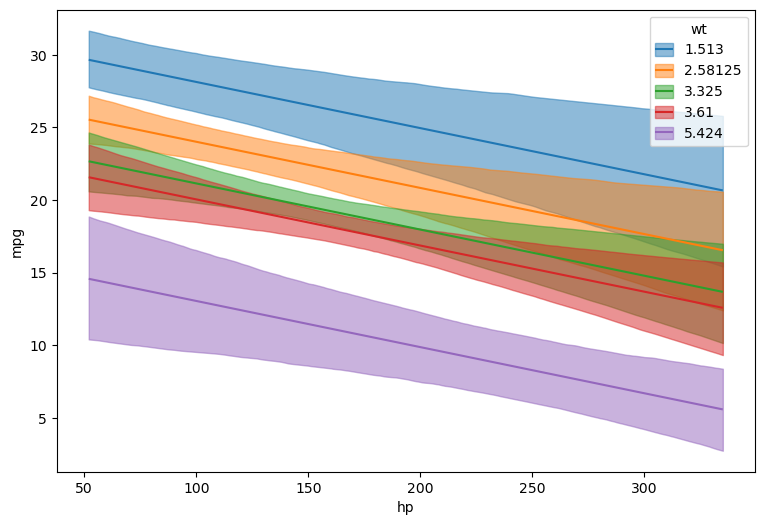

In [ ]:
plot_cap(model_main, idata_main, ["hp", "wt"], use_hdi=False, fig_kwargs={"figsize": (9, 6)});

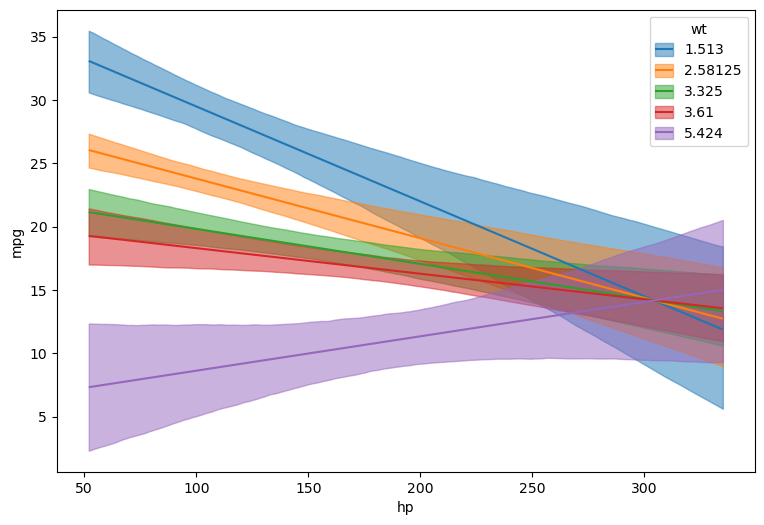

In [ ]:
plot_cap(model_interaction, idata_interaction, ["hp", "wt"], use_hdi=False, fig_kwargs={"figsize": (9, 6)});

## Exercise 7: A model with many predictors 

This is the continuation of Exercise 4 from the previous lesson, where we worked with the construction problem. Now we're going to use all the predictors, not just cement and water, to predict the concrete strength. 

The goal of this exercise is to learn how scaling of the predictors may help our sampler to work faster. Also, it challenges you to come up with an alternative that will prevent our model from giving negative predictions, a problem we already detected in Exercise 4 from the previous lesson.

If you want to refresh your knowledge about the `scale()` transform, revisit the section "Transformations in Bambi".

### The data

The team has already tested more than a thousand samples ([source](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)) and the following variables were measured and recorded

* **cement** - Portland cement in kg/m3
* **slag** - Blast furnace slag in kg/m3
* **fly_ash** - Fly ash in kg/m3
* **water** - Water in liters/m3
* **superplasticizer** - Superplasticizer additive in kg/m3
* **coarse_aggregate** - Coarse aggregate (gravel) in kg/m3
* **fine_aggregate** - Fine aggregate (sand) in kg/m3
* **age** - Age of the sample in days
* **strength** - Concrete compressive strength in megapascals (MPa)

In [3]:
concrete_data = pd.read_csv("data/concrete.csv")
concrete_data.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
concrete_data_new = pd.DataFrame(
    {
        "cement": [520, 300, 400],
        "slag": [100, 50, 70],
        "fly_ash": [120, 40, 90],
        "water": [228, 160, 200],
        "superplasticizer": [22, 16, 20],
        "coarse_aggregate": [1000, 800, 900],
        "fine_aggregate": [825, 650, 775],
        "age": [48, 128, 80],
    }
)

### The models

Since we're using all the predictors, the formulas are quite big. We could build them using Python, but for the sake of clarity we prefer to just write them down.

**Unscaled model**

```python
formula = "strength ~ cement + slag + fly_ash + water + superplasticizer + coarse_aggregate + fine_aggregate + age"
```

**Scaled model**

```python
formula = "strength ~ scale(cement) + scale(slag) + scale(fly_ash) + scale(water) + scale(superplasticizer) + scale(coarse_aggregate) + scale(fine_aggregate) + scale(age)"
```

### The questions

* Build and fit the unscaled model
* Build and fit the scaled model
* Compare sampling times
* Predict the weight of the three samples in the data frame `concrete_data_new` using both models
    * Do predictions differ between models?
    * Why?
* Plot the posterior predictive distribution
    * If the model predicts negative strenghts, propose a model that fixes this problem.
    * Fit the new model and explore the posterior predictive distribution again.
    * What can you conclude?

In [5]:
formula = "strength ~ cement + slag + fly_ash + water + superplasticizer + coarse_aggregate + fine_aggregate + age"
model_unscaled = bmb.Model(formula, concrete_data)
idata_unscaled = model_unscaled.fit(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, cement, slag, fly_ash, water, superplasticizer, coarse_aggregate, fine_aggregate, age, strength_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [6]:
formula = "strength ~ scale(cement) + scale(slag) + scale(fly_ash) + scale(water) + scale(superplasticizer) + scale(coarse_aggregate) + scale(fine_aggregate) + scale(age)"
model_scaled = bmb.Model(formula, concrete_data)
idata_scaled = model_scaled.fit(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, scale(cement), scale(slag), scale(fly_ash), scale(water), scale(superplasticizer), scale(coarse_aggregate), scale(fine_aggregate), scale(age), strength_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [7]:
model_unscaled.predict(idata_unscaled, data=concrete_data_new, kind="pps")
model_scaled.predict(idata_scaled, data=concrete_data_new, kind="pps")

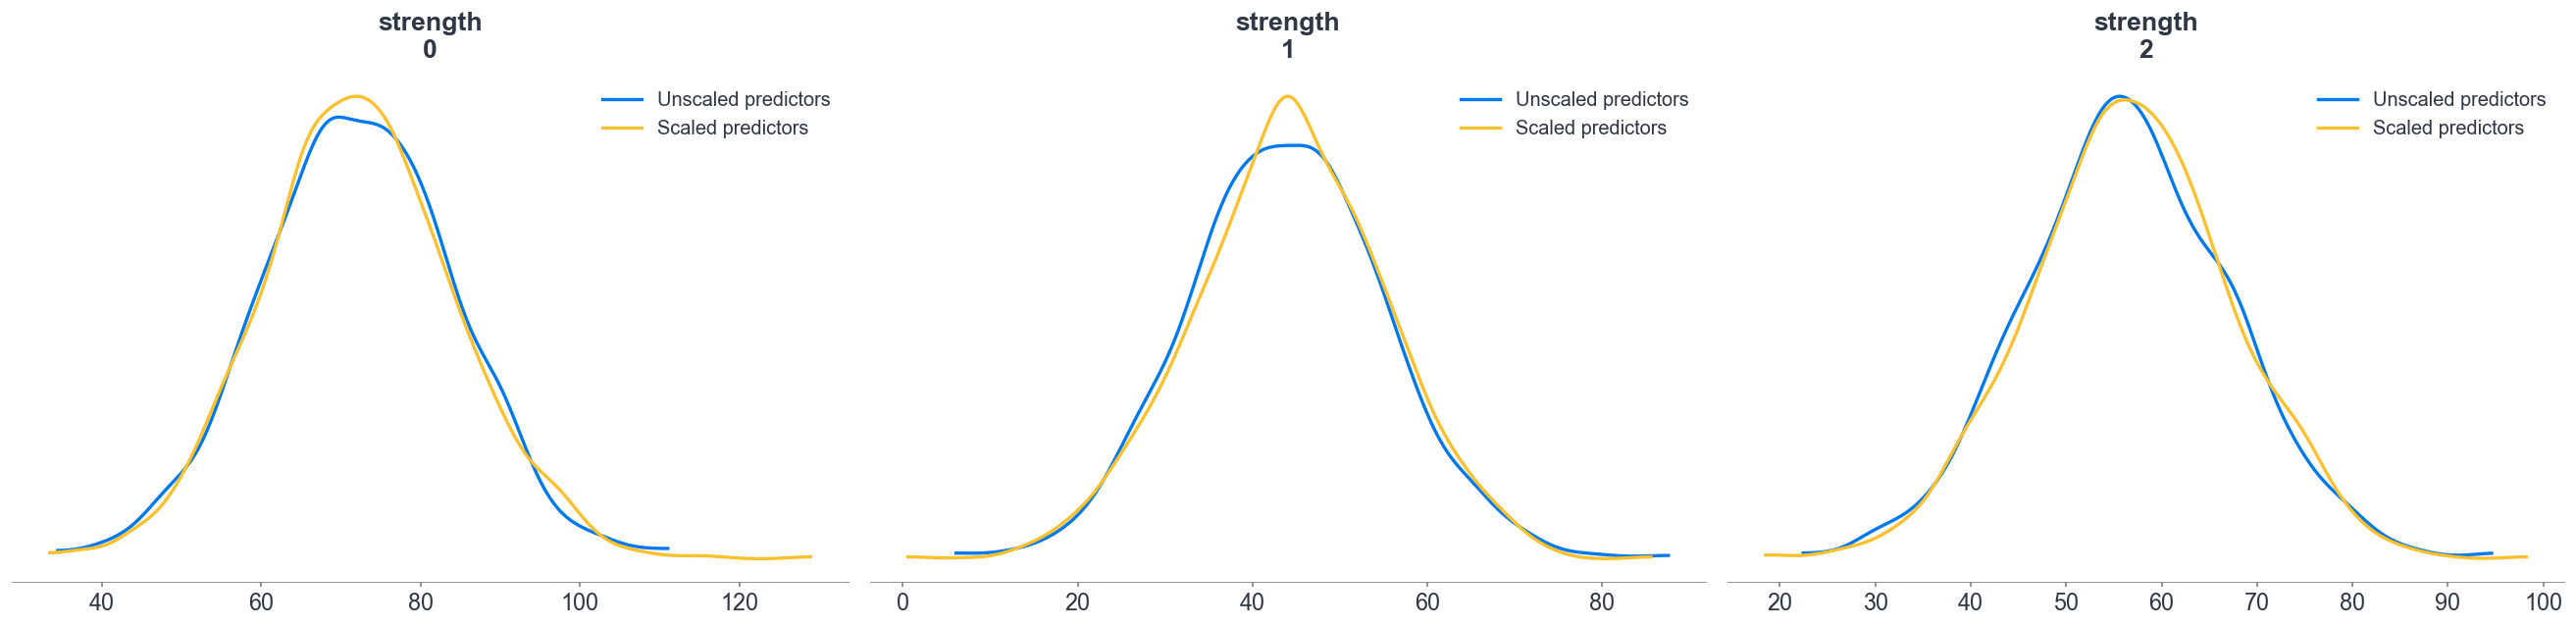

In [8]:
axes = az.plot_posterior(
    idata_unscaled.posterior_predictive["strength"],
    hdi_prob="hide",
    point_estimate=None,
    lw=2,
    label="Unscaled predictors"
)
az.plot_posterior(
    idata_scaled.posterior_predictive["strength"],
    hdi_prob="hide", 
    point_estimate=None,
    ax=axes, 
    color="C1",
    lw=2,
    label="Scaled predictors"
)
plt.tight_layout()

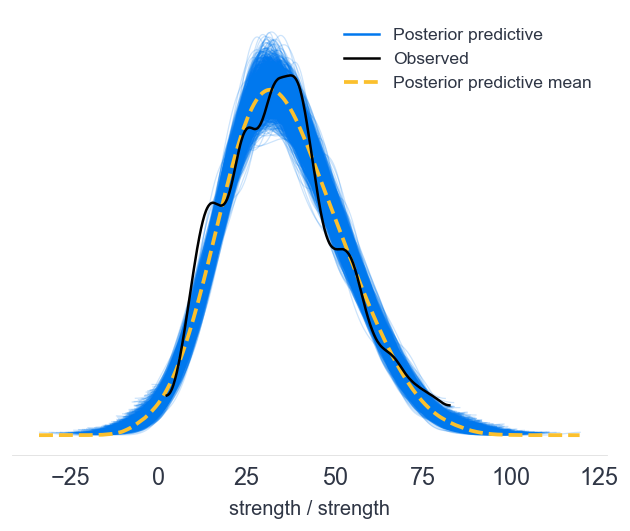

In [9]:
model_scaled.predict(idata_scaled, kind="pps")
az.plot_ppc(idata_scaled);

Alternative model using a logarithm transformation for the response.

In [24]:
formula = "log(strength) ~ scale(cement) + scale(slag) + scale(fly_ash) + scale(water) + scale(superplasticizer) + scale(coarse_aggregate) + scale(fine_aggregate) + scale(age)"
model_alternative = bmb.Model(formula, concrete_data)
idata_alternative = model_alternative.fit(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, scale(cement), scale(slag), scale(fly_ash), scale(water), scale(superplasticizer), scale(coarse_aggregate), scale(fine_aggregate), scale(age), log(strength)_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


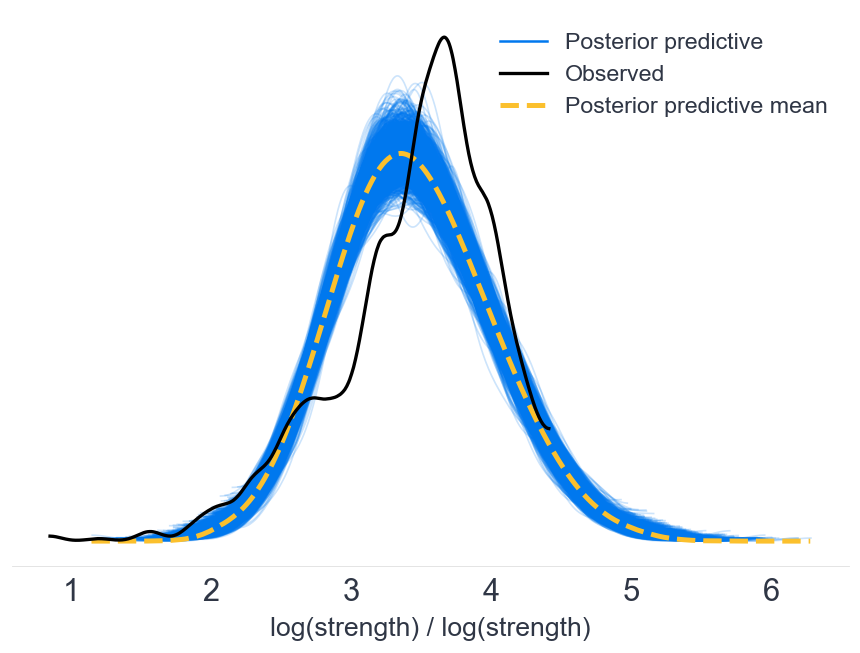

In [25]:
model_alternative.predict(idata_alternative, kind="pps")
az.plot_ppc(idata_alternative, figsize=(9, 6));

In [26]:
idata_alternative.posterior_predictive["strength"] = np.exp(idata_alternative.posterior_predictive["log(strength)"])
idata_alternative.observed_data["strength"] = np.exp(idata_alternative.observed_data["log(strength)"])

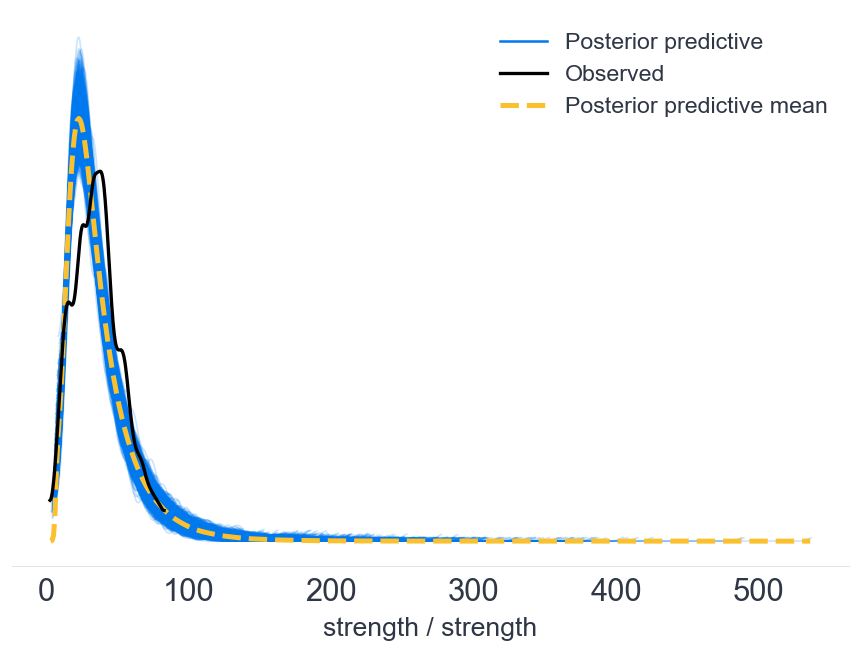

In [27]:
az.plot_ppc(idata_alternative, var_names="strength", figsize=(9, 6));

### Citations

The data for this exercise originally comes from

* I-Cheng Yeh, "Modeling of strength of high performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998).